In [1]:
# Importing libraries

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Setting random seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [2]:
# Opening the dataframe and setting the index
Univariate_data = pd.read_csv('../input/electricity-demand/Univariate_Labeled.csv', parse_dates=['DateTime'])
Univariate_data['DayOfWeek'] = Univariate_data['DateTime'].dt.day_of_week # Introducing the day of the week
Univariate_data.drop(columns='DateTime', inplace=True) # Removing DateTime (we have the day of the week)
Univariate_data = Univariate_data[0:34944] # 52 weeks
Univariate_data

,Consumption,Anomaly,DayOfWeek
0,950.0,0,2
1,939.0,0,2
2,943.0,0,2
3,971.0,0,2
4,1014.0,0,2
...,...,...,...
34939,886.0,0,1
34940,883.0,0,1
34941,868.0,0,1
34942,872.0,0,1


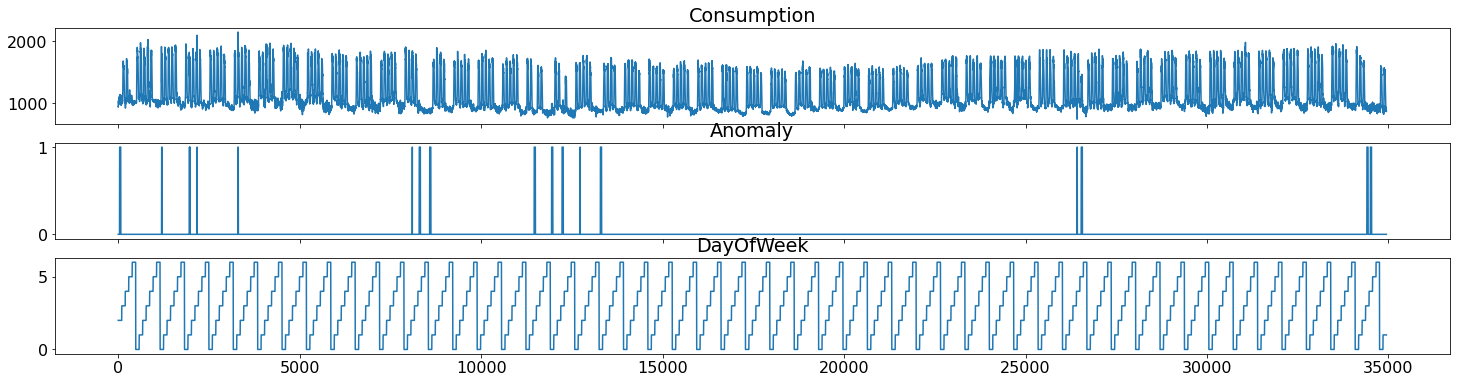

In [3]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(25,6))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [4]:
# Columns used for the following split in train, test and validation sets
Univariate_data['Test'] = 0
Univariate_data['Validation'] = 0
Univariate_data['Train_P1'] = 0
Univariate_data['Train_P2'] = 0
Univariate_data['Train_P3'] = 0
Univariate_data

,Consumption,Anomaly,DayOfWeek,Test,Validation,Train_P1,Train_P2,Train_P3
0,950.0,0,2,0,0,0,0,0
1,939.0,0,2,0,0,0,0,0
2,943.0,0,2,0,0,0,0,0
3,971.0,0,2,0,0,0,0,0
4,1014.0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...
34939,886.0,0,1,0,0,0,0,0
34940,883.0,0,1,0,0,0,0,0
34941,868.0,0,1,0,0,0,0,0
34942,872.0,0,1,0,0,0,0,0


In [5]:
# TEST SET

# Weeks containing anomalies
for i in range (52):
    Slice_Univariate_data = Univariate_data.iloc[(i)*672:(i+1)*672]
    if(Slice_Univariate_data['Anomaly'].sum() != 0):
        Univariate_data.iloc[(i)*672:(i+1)*672]['Test'] = 1

In [6]:
# VALIDATION SET

# Some random weeks
week = [40,41,42,43,44,45,46,47,48,49,50]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    Univariate_data.iloc[(j)*672:(j+1)*672]['Validation'] = 1

In [7]:
# TRAINING SET

week = [5,6,7,8,9,10,11]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    Univariate_data.iloc[(j)*672:(j+1)*672]['Train_P1'] = 1
    
week = [13,14,15,16]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    Univariate_data.iloc[(j)*672:(j+1)*672]['Train_P2'] = 1
    
week = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]
for j in week:
    Slice_Univariate_data = Univariate_data.iloc[(j)*672:(j+1)*672]
    Univariate_data.iloc[(j)*672:(j+1)*672]['Train_P3'] = 1

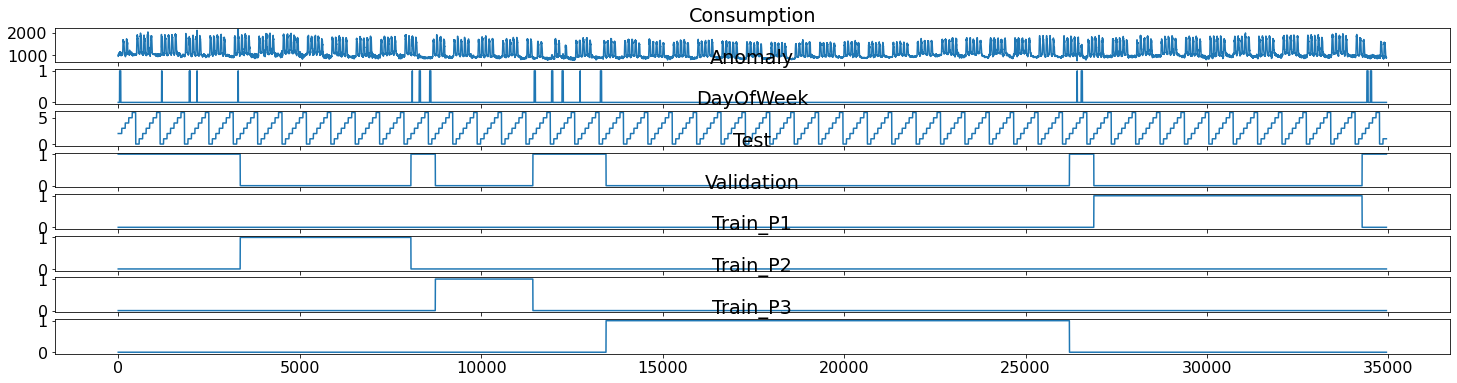

In [8]:
# Plotting time series
inspect_dataframe(Univariate_data, Univariate_data.columns)

In [9]:
# TRAIN, TEST, VALIDATION SETS
X_train_temp_P1 = Univariate_data[Univariate_data['Train_P1']==1].copy()
X_train_temp_P2 = Univariate_data[Univariate_data['Train_P2']==1].copy()
X_train_temp_P3 = Univariate_data[Univariate_data['Train_P3']==1].copy()
X_validation_temp = Univariate_data[Univariate_data['Validation']==1].copy()
X_test_temp = Univariate_data[Univariate_data['Test']==1].copy()

In [10]:
# Training, Validation and Test set - Anomalies (not used for training)
Anomaly_Train_P1 = X_train_temp_P1[['Anomaly']]
Anomaly_Train_P2 = X_train_temp_P2[['Anomaly']]
Anomaly_Train_P3 = X_train_temp_P3[['Anomaly']]
Anomaly_Validation = X_validation_temp[['Anomaly']]
Anomaly_Test = X_test_temp[['Anomaly']]

In [11]:
temp = pd.concat([X_train_temp_P1,X_train_temp_P2],axis=0)
X_train_temp_global = pd.concat([X_train_temp_P3,temp],axis=0)
X_train_temp_global.shape

(20160, 8)

In [12]:
# STANDARDIZATION

mean = X_train_temp_global.mean()
std_dev = X_train_temp_global.std()
print(mean, std_dev)

X_train_raw_P1 = (X_train_temp_P1-mean)/std_dev
X_train_raw_P2 = (X_train_temp_P2-mean)/std_dev
X_train_raw_P3 = (X_train_temp_P3-mean)/std_dev
X_validation_raw = (X_validation_temp-mean)/std_dev
X_test_raw = (X_test_temp-mean)/std_dev

print(X_test_raw.shape[0]+X_validation_raw.shape[0]+X_train_raw_P1.shape[0]+X_train_raw_P2.shape[0]+X_train_raw_P3.shape[0] == Univariate_data.shape[0])

Consumption    1136.788542
Anomaly           0.000000
DayOfWeek         3.000000
Test              0.000000
Validation        0.000000
Train_P1          0.233333
Train_P2          0.133333
Train_P3          0.633333
dtype: float64 Consumption    282.830237
Anomaly          0.000000
DayOfWeek        2.000050
Test             0.000000
Validation       0.000000
Train_P1         0.422963
Train_P2         0.339943
Train_P3         0.481906
dtype: float64
True


In [13]:
# Anomalies are not considered during the training
X_train_raw_P1 = X_train_raw_P1[['Consumption', 'DayOfWeek']]
X_train_raw_P2 = X_train_raw_P2[['Consumption', 'DayOfWeek']]
X_train_raw_P3 = X_train_raw_P3[['Consumption', 'DayOfWeek']]
X_validation_raw = X_validation_raw[['Consumption', 'DayOfWeek']]
X_test_raw = X_test_raw[['Consumption', 'DayOfWeek']]
X_train_raw_P1.shape, X_train_raw_P2.shape, X_train_raw_P3.shape, X_validation_raw.shape, X_test_raw.shape

((4704, 2), (2688, 2), (12768, 2), (7392, 2), (7392, 2))

In [14]:
X_train_raw_P1.reset_index(inplace=True)
X_train_raw_P1.drop(columns='index', inplace=True)
X_train_raw_P2.reset_index(inplace=True)
X_train_raw_P2.drop(columns='index', inplace=True)
X_train_raw_P3.reset_index(inplace=True)
X_train_raw_P3.drop(columns='index', inplace=True)
X_validation_raw.reset_index(inplace=True)
X_validation_raw.drop(columns='index', inplace=True)
X_test_raw.reset_index(inplace=True)
X_test_raw.drop(columns='index', inplace=True)

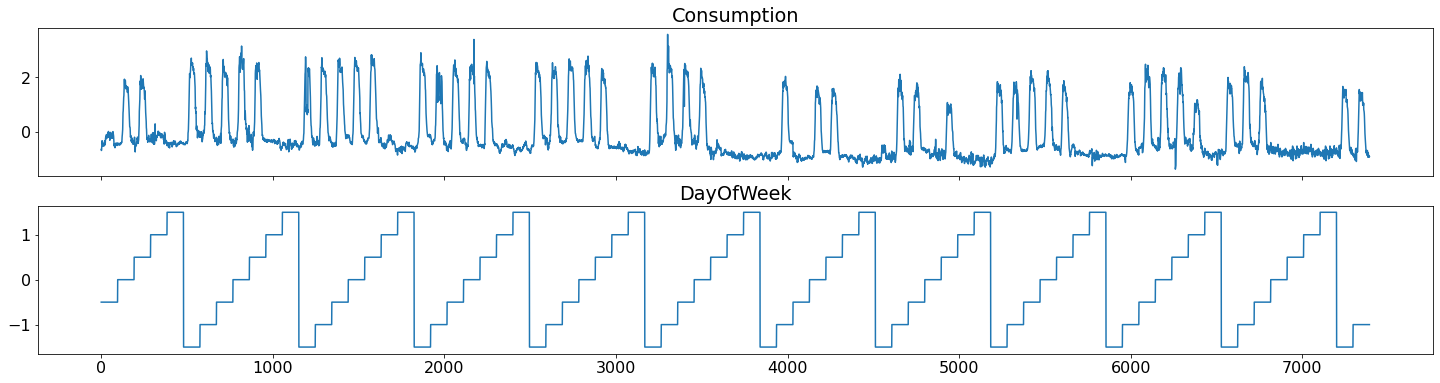

In [15]:
# Plotting time series
inspect_dataframe(X_test_raw, X_test_raw.columns)

## Training - Preparation

In [16]:
# Training parameters

window = 672       # 1 week
stride = 4         # 1 hour
latent_dim = 10    # Latent dimension
epochs = 200       # Number of epochs (no early stopping)
batch_size = 8     # Batch size
M = 200            # Montecarlo
alpha = 0.5

In [17]:
# Function used to create (overlapped) windows that we will use for the training
def build_sequences(df, anomaly, window=window, stride=stride):
    
    assert len(df) > window
    dataset = []
    anomalies = []
    temp_df = df.copy().values
    temp_an = anomaly.copy().values
    padding_len = (len(df)-window)%stride # Padding computed considering the stride
    print("PADDING: " + str(padding_len)) #DEBUG

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_an.shape[1]), dtype='float32')
        temp_an = np.concatenate((padding,temp_an))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])
        anomalies.append(temp_an[idx:idx+window])

    dataset = np.array(dataset)
    anomalies = np.array(anomalies)
    return dataset, anomalies

In [18]:
X_train_P1, A_train_P1 = build_sequences(X_train_raw_P1, Anomaly_Train_P1, window=window, stride=stride)
X_train_P2, A_train_P2 = build_sequences(X_train_raw_P2, Anomaly_Train_P2, window=window, stride=stride)
X_train_P3, A_train_P3 = build_sequences(X_train_raw_P3, Anomaly_Train_P3, window=window, stride=stride)
X_val, A_val = build_sequences(X_validation_raw, Anomaly_Validation, window=window, stride=stride)
X_train_P1.shape,X_train_P2.shape,X_train_P3.shape

PADDING: 0
PADDING: 0
PADDING: 0
PADDING: 0


((1009, 672, 2), (505, 672, 2), (3025, 672, 2))

In [19]:
X_train = np.concatenate([X_train_P1,X_train_P2],axis=0)
X_train = np.concatenate([X_train,X_train_P3],axis=0)
A_train = np.concatenate([A_train_P1,A_train_P2],axis=0)
A_train = np.concatenate([A_train,A_train_P3],axis=0)
X_train.shape, A_train.shape

((4539, 672, 2), (4539, 672, 1))

In [20]:
X_test, A_test = build_sequences(X_test_raw, Anomaly_Test, window=window, stride=window) 
X_test.shape

PADDING: 0


(11, 672, 2)

## Building the model + Training

In [21]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [22]:
# Reparametrization trick
def sample(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), seed=seed)
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [23]:
# Building the model

from keras import backend as K
from tensorflow.keras import Input

input_shape = X_train.shape[1:]
output_shape = X_train.shape[1:]

###########
# ENCODER #
###########

encoder_input = tf.keras.Input(shape=input_shape)

x = tfkl.LSTM(64, return_sequences=False)(encoder_input)

x = tfkl.Dense(latent_dim, activation='linear')(x)

# Latent representation: mean + log of std.dev.
z_mu = tfkl.Dense(latent_dim, name='latent_mu')(x) # Mean
z_sigma = tfkl.Dense(latent_dim, name='latent_sigma')(x) # Std.Dev. 

# Sampling a vector from the latent distribution
z = tfkl.Lambda(sample, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

encoder = tfk.Model(encoder_input, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

2022-08-10 06:13:24.779155: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 672, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 64)           17152       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           650         lstm[0][0]                       
__________________________________________________________________________________________________
latent_mu (Dense)               (None, 10)           110         dense[0][0]                      
____________________________________________________________________________________________

In [24]:
###########
# DECODER #
###########

decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
convlstm = tfkl.RepeatVector(window)(decoder_input)
convlstm = tfkl.LSTM(64, return_sequences=True)(convlstm)
decoder_output = tfkl.TimeDistributed(tfkl.Dense(output_shape[1]))(convlstm)

# Define and summarize decoder model
decoder = tfk.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 10)]              0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 672, 10)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 672, 64)           19200     
_________________________________________________________________
time_distributed (TimeDistri (None, 672, 2)            130       
Total params: 19,330
Trainable params: 19,330
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Sampling + Reparametrization trick
def sample_z1(z_m, z_l_v):
    z_mean = z_m 
    z_log_var = z_l_v
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), seed=seed)
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [26]:
class VAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def forward(self, x):
        outputs = {}
        
        z_mu, z_log_var, _ = self.encoder(x)
        z = sample_z1(z_mu,z_log_var)
        reconstruction = self.decoder(z)
        
        outputs["z_mu"] = z_mu
        outputs["z_log_var"] = z_log_var
        outputs["z"] = z
        outputs["reconstruction"] = reconstruction
        
        return outputs

    def train_step(self, y_true):
        with tf.GradientTape() as tape:
            
            z_mu, z_log_var, _ = self.encoder(y_true)
            z = sample_z1(z_mu,z_log_var)
            y_predict = self.decoder(z)
          
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(y_true, y_predict), axis=1))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }
    
    def test_step(self, data): #https://github.com/keras-team/keras-io/issues/38

        z_mu, z_log_var, _ = self.encoder(data)
        z = sample_z1(z_mu,z_log_var)
        y_predict = self.decoder(z)
          
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y_predict), axis=1))
            
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }

In [27]:
vae = VAE(encoder, decoder)

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

vae.compile(optimizer=tfk.optimizers.Adam())
vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=50, 
        batch_size=batch_size)
vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=24, 
        batch_size=batch_size,
        callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)]
       )

2022-08-10 06:13:25.790800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
568/568 [==============================] - 492s 857ms/step - loss: 672.6626 - reconstruction_loss: 667.3053 - kl_loss: 0.2618 - val_loss: 807.0488 - val_reconstruction_loss: 806.6449 - val_kl_loss: 0.4039
Epoch 2/50
568/568 [==============================] - 490s 864ms/step - loss: 664.9336 - reconstruction_loss: 664.7792 - kl_loss: 0.4552 - val_loss: 795.5920 - val_reconstruction_loss: 795.0554 - val_kl_loss: 0.5366
Epoch 3/50
568/568 [==============================] - 485s 854ms/step - loss: 662.7584 - reconstruction_loss: 662.6840 - kl_loss: 2.0997 - val_loss: 815.1838 - val_reconstruction_loss: 814.2756 - val_kl_loss: 0.9081
Epoch 4/50
568/568 [==============================] - 490s 862ms/step - loss: 663.6109 - reconstruction_loss: 661.4063 - kl_loss: 1.6541 - val_loss: 810.2682 - val_reconstruction_loss: 807.6346 - val_kl_loss: 2.6337
Epoch 5/50
568/568 [==============================] - 487s 857ms/step - loss: 641.0279 - reconstruction_loss: 624.2535 - kl_loss: 5.6031

 ## Example of prediction on the test set

In [28]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [29]:
_, _, encoded_data = encoder(X_test) 
predictions = decoder(encoded_data)

for l in range(M-1):
    _, _, encoded_data = encoder(X_test) 
    reconstruction = decoder(encoded_data)
    predictions = predictions + reconstruction
    
predictions = predictions/M
print(predictions.shape)

(11, 672, 2)


In [30]:
def inspect_multivariate_prediction(X, y, a, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(pred))

    figs, axs = plt.subplots(len(columns) + 1, 1, sharex=True, figsize=(17,10))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
           
    axs[len(columns)].plot(np.arange(len(X[0,:,i])), a[idx,:])
    axs[len(columns)].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope, ), a[idx,:])
    axs[len(columns)].set_title('Anomaly')
    plt.show()

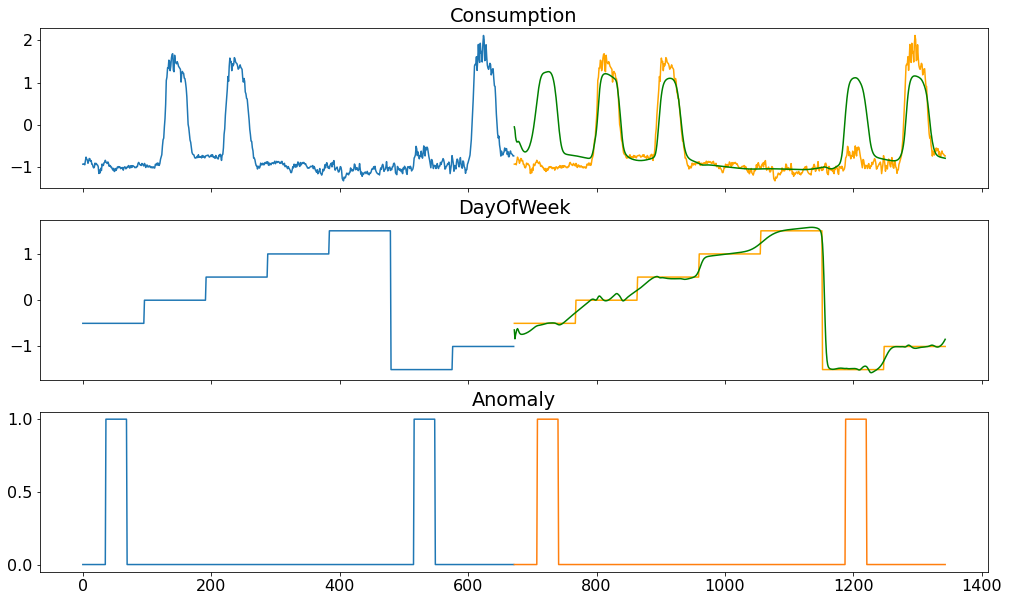

In [31]:
# Plotting predictions
target_labels = X_test_raw.columns
inspect_multivariate_prediction(X_test, X_test, A_test, predictions, target_labels, window)

## Computing reconstruction error

In [32]:
# Function used to create non-overlapped windows starting from the TRAINING set
def build_sequences_reconstruction(df, window, stride):
    dataset = []
    temp_df = df.copy().values
    padding_len = (len(df)-window)%stride

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])

    dataset = np.array(dataset)
    return dataset

In [33]:
# Non overlapped windows - Training set
X_train_non_overlapped_P1 = build_sequences_reconstruction(X_train_raw_P1, window=window, stride=window)
X_train_non_overlapped_P2 = build_sequences_reconstruction(X_train_raw_P2, window=window, stride=window)
X_train_non_overlapped_P3 = build_sequences_reconstruction(X_train_raw_P3, window=window, stride=window)

X_train_non_overlapped = np.concatenate([X_train_non_overlapped_P1,X_train_non_overlapped_P2],axis=0)
X_train_non_overlapped = np.concatenate([X_train_non_overlapped,X_train_non_overlapped_P3],axis=0)

X_train_non_overlapped.shape

(30, 672, 2)

In [34]:
test_weeks = [0,1,2,3,4,12,17,18,19,39,51] # Weeks that are in the test set
indexes = [0,5,6,9,10] # Considering positions in "text_weeks", indexes of weeks to be considered on alone (non consecutive)
full_seq_index = [] # Tells us which windows of X_Test_Overlapped have to be fully considered (for all the other windows we will consider last "stride" elements)

counter = 0 # Tells us which window of X_Test_Overlapped we're considering

X_test_overlapped = np.empty(shape=(0, 672, 2))

for i in range(len(indexes)): # For all windows to be considered on alone ...
    
    # Interval of consecutive weeks to be considered
    left = indexes[i]
    if i+1 < len(indexes):
        right = indexes[i+1]
    else:
        right = indexes[-1] + 1
    
    full_seq_index.append(counter)
    df = X_test_raw.iloc[(left)*672:(right)*672].copy()
    dataset = build_sequences_reconstruction(df, window, stride) # Creating sequences using consecutive weeks we have identified
    counter = counter + dataset.shape[0]
    X_test_overlapped = np.concatenate((X_test_overlapped, dataset[:,:,:2]), axis=0) # We concatenate new windows created
        
X_test_overlapped.shape, full_seq_index

((1013, 672, 2), [0, 673, 674, 1011, 1012])

In [35]:
# Making predictions on non-overlapped windows of the training set
encoded_data = encoder(X_train_non_overlapped)[-1]
print(encoded_data.shape)
train_reconstructions = decoder(encoded_data)
print(train_reconstructions.shape)

for l in range(M-1):
    encoded_data = encoder(X_train_non_overlapped)[-1]
    train_prediction = decoder(encoded_data)
    train_reconstructions = train_prediction + train_reconstructions
    
train_reconstructions = train_reconstructions/M
print(train_reconstructions.shape)

(30, 10)
(30, 672, 2)
(30, 672, 2)


In [36]:
# Making predictions on overlapped windows of the test set
encoded_data = encoder(X_test_overlapped)[-1]
print(encoded_data.shape)
test_reconstructions = decoder(encoded_data)
print(test_reconstructions.shape)

for l in range(M-1):
    encoded_data = encoder(X_test_overlapped)[-1]
    test_prediction = decoder(encoded_data)
    test_reconstructions = test_prediction + test_reconstructions
    
test_reconstructions = test_reconstructions/M
print(test_reconstructions.shape)

(1013, 10)
(1013, 672, 2)
(1013, 672, 2)


In [37]:
# Function used to plot predictions (reconstructions) made on training data using the model
def inspect_multivariate_prediction_reconstruction(X, y, a, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(pred))
        print('Plotting sequence number: ' + str(idx))

    figs, axs = plt.subplots(2, 1, sharex=True, figsize=(17,7))
    for i, col in enumerate(columns[:4]):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

Plotting sequence number: 19


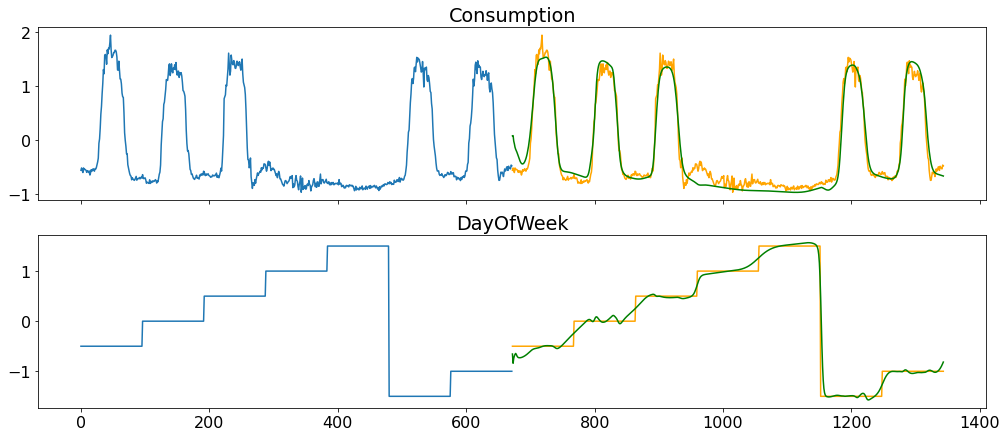

In [38]:
# Plotting reconstructions of the TRAINING set
inspect_multivariate_prediction_reconstruction(X_train_non_overlapped, X_train_non_overlapped, A_train, train_reconstructions, target_labels, window)

In [39]:
# Array that will contain reconstruction errors (floor by floor) - TRAINING SET
reconstruction_errors = np.empty(shape=(0, 1))

# Computing reconstruction errors
for i in range(X_train_non_overlapped.shape[0]):
    error = np.abs(X_train_non_overlapped[i]-train_reconstructions[i])
    error = error[:,:1] # Not interested in the day of the week
    reconstruction_errors = np.concatenate((reconstruction_errors,error), axis=0)
    
mean_error = np.mean(reconstruction_errors, axis = 0) # Mean reconstruction error
std_error = np.std(reconstruction_errors, axis = 0) # Std dev of the reconstruction error
max_error = np.max(reconstruction_errors, axis = 0) # Max error on the training set
  
print(reconstruction_errors.shape) # 34944 = 52 weeks * 672 samples/week
print(mean_error)
print(std_error)
print(max_error)

(20160, 1)
[0.15313565]
[0.14607001]
[1.29385233]


In [40]:
# Function used to predict anomalies
def predict_anomalies(reconstruction_errors, error_threshold):
    
    # Inizially we don't have predicted anomalies
    anomaly_predicted = np.zeros(shape=(X_test_raw.shape[0]))
    
    i = 0
    for seq in reconstruction_errors:
        for sample in seq: 
            epsilon = sample - error_threshold # We check if the reconstruction error is greater than the threshold
            if epsilon > 0:
                anomaly_predicted[i] = 1
            i = i+1

    return anomaly_predicted

In [41]:
# Array that will contain reconstruction errors (floor by floor) - TEST SET

reconstruction_test = np.empty(shape=(0, 1)) # Predictions made on the test set using the model
reconstruction_errors_test = np.empty(shape=(0, 1)) # Errors made in predicting the test set

for i in range(X_test_overlapped.shape[0]):
    if i in full_seq_index: # Windows to be entirely considered
        error = np.abs(X_test_overlapped[i]-test_reconstructions[i])
        error = error[:,:1] # Not interested in the day of the week
        reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
        reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,:,:1]), axis=0)
    else: # Windows for which we have to consider only last "stride" elements
        error = np.abs(X_test_overlapped[i,-stride:,:]-test_reconstructions[i,-stride:,:])
        error = error[:,:1] # Not interested in the day of the week
        reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
        reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,-stride:,:1]), axis=0)
                                        
print(reconstruction_errors_test.shape)
print(reconstruction_test.shape)

(7392, 1)
(7392, 1)


In [42]:
# Grid search threshold parameters

range_of_val = [x for x in np.arange(2, 11, 0.1)]
best_val = 0
F1_MAX = 0

for i in range_of_val:
    threshold_error_mean_std_TEMP = 0
    threshold_error_mean_std_TEMP = mean_error + i*std_error # mean + n*std_dev
    anomaly_predicted_mean_std_TEMP = 0
    anomaly_predicted_mean_std_TEMP = predict_anomalies(reconstruction_errors_test, threshold_error_mean_std_TEMP)
    f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted_mean_std_TEMP)
    if(f1>F1_MAX):
        F1_MAX = f1
        best_val = i
        print("best threshold parameters: " + str(best_val) + " best f1: " + str(F1_MAX))
            
threshold_error_mean_std = mean_error + best_val*std_error # mean + n*std_dev
anomaly_predicted_mean_std = predict_anomalies(reconstruction_errors_test, threshold_error_mean_std)
                
threshold_error_max = max_error # Max error on the training set
anomaly_predicted_max = predict_anomalies(reconstruction_errors_test, threshold_error_max)

anomaly_predicted_mean_std.sum(), anomaly_predicted_max.sum(), anomaly_predicted_mean_std.shape, anomaly_predicted_max.shape, threshold_error_mean_std, threshold_error_max

best threshold parameters: 2.0 best f1: 0.5093684941013185
best threshold parameters: 2.1 best f1: 0.5239114917915775
best threshold parameters: 2.2 best f1: 0.5408990420044215
best threshold parameters: 2.3000000000000003 best f1: 0.556060606060606
best threshold parameters: 2.4000000000000004 best f1: 0.5667953667953669
best threshold parameters: 2.5000000000000004 best f1: 0.5839299920445505
best threshold parameters: 2.6000000000000005 best f1: 0.595606183889341
best threshold parameters: 2.7000000000000006 best f1: 0.6068162926018288
best threshold parameters: 2.8000000000000007 best f1: 0.620748299319728
best threshold parameters: 2.900000000000001 best f1: 0.6330434782608696
best threshold parameters: 3.000000000000001 best f1: 0.641409691629956
best threshold parameters: 3.100000000000001 best f1: 0.6594202898550725
best threshold parameters: 3.200000000000001 best f1: 0.6691244239631335
best threshold parameters: 3.300000000000001 best f1: 0.6810912511759172
best threshold par

(350.0, 354.0, (7392,), (7392,), array([1.30708871]), array([1.29385233]))

In [43]:
padding_len = (len(X_test_raw)-window)%stride
size = X_test_raw.shape[0]-padding_len
X_test_raw = X_test_raw[:size]

In [44]:
Anomaly_Test.reset_index(inplace=True)
Anomaly_Test.drop(columns='index', inplace=True)

In [45]:
# Adding ptdictions and predicted anomalies to X_test_raw
X_test_raw['Reconstr'] = reconstruction_test[:,0] # Prediction on floor 1
X_test_raw['Anomaly_Label_GT'] = Anomaly_Test # Ground truth anomalies
X_test_raw['Anomaly_Predicted_Mean_Std'] = anomaly_predicted_mean_std[:X_test_raw.shape[0]] # Anomalies predicted using mean and std dev
X_test_raw['Anomaly_Predicted_Max'] = anomaly_predicted_max[:X_test_raw.shape[0]] # Anomalies predicted using max error on the training set
X_test_raw['Error'] = reconstruction_errors_test[:,0] # Prediction error on floor 1
X_test_raw.head()

import datetime as dt

X = np.array(X_test_raw.iloc[:672][['Consumption']])
predictions = np.array(X_test_raw.iloc[:672][['Reconstr']])
anomaly_true = X_test_raw.iloc[:672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.iloc[:672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.iloc[:672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.iloc[:672]['Error']

In [46]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [47]:
import datetime as dt

i=4
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['Consumption']])
predictions = np.array(X_test_raw.iloc[i*672:j*672][['Reconstr']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.iloc[i*672:j*672]['Error']

In [48]:
def inspect_multivariate_prediction(X, y, a_true, a_predicted_mean_std, a_predicted_max, pred, columns, error_1F): 
   
    figs, axs = plt.subplots(5, 1, sharex=True, figsize=(17,17)) 
    for i, col in enumerate(columns[:1]): 
        axs[i].plot(np.arange(len(X[:,i])), X[:,i]) 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), y[:,i], color='orange') 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), pred[:,i], color='green') 
        axs[i].set_title(col) 
        
    axs[1].plot(np.arange(len(X[:,i])), error_1F) 
    axs[1].plot(np.arange(len(X[:,i]), len(X[:,i])*2), error_1F) 
    axs[1].set_title('error') 
            
    axs[2].plot(np.arange(len(X[:,i])), a_true) 
    axs[2].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_true) 
    axs[2].set_title('Anomaly_True') 
    
    axs[3].plot(np.arange(len(X[:,i])), a_predicted_mean_std) 
    axs[3].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_mean_std) 
    axs[3].set_title('Anomaly_Predicted_Mean_Std_Dev')
    
    axs[4].plot(np.arange(len(X[:,i])), a_predicted_max) 
    axs[4].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_max) 
    axs[4].set_title('Anomaly_Predicted_Max') 
    plt.show()

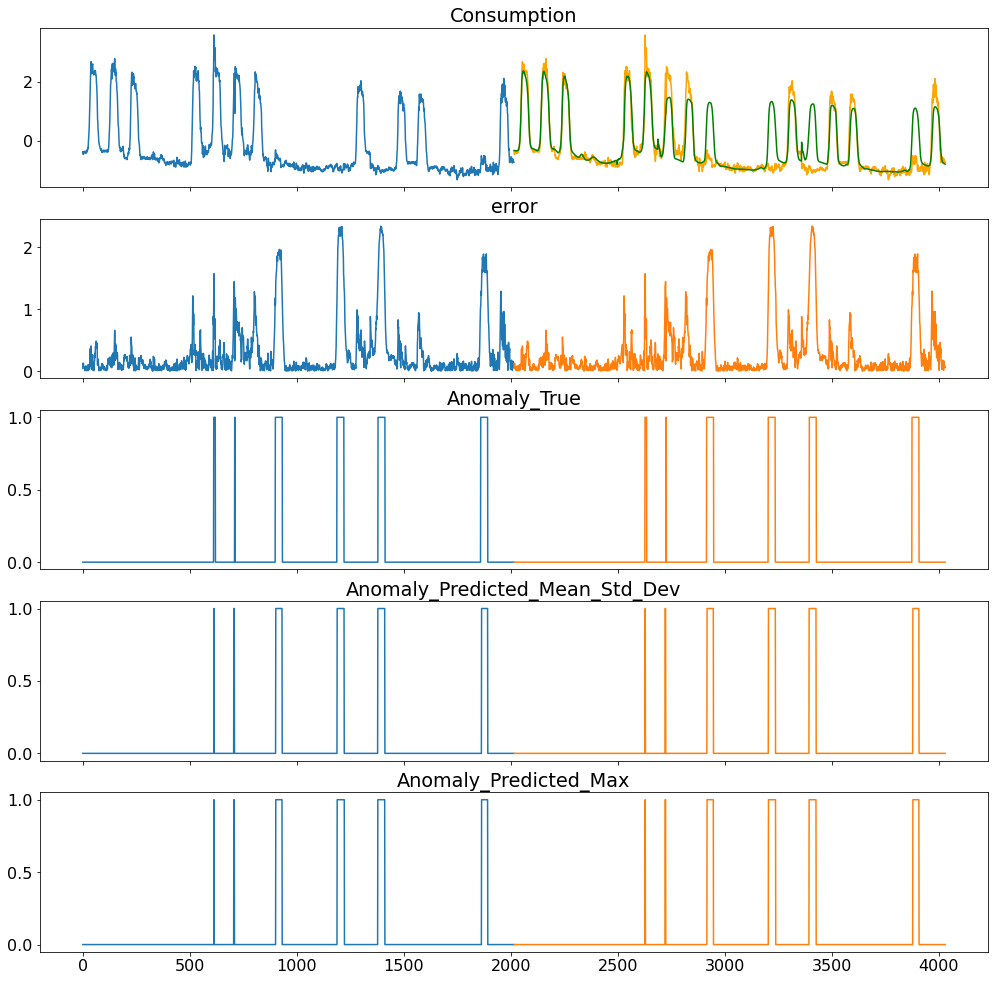

In [49]:
# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F) # X = ABB_print

Accuracy: 0.9885
Precision: 0.9086
Recall: 0.8571
F1: 0.8821


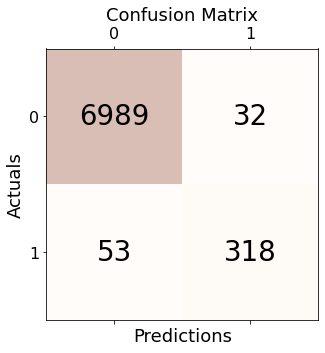

In [50]:
anomaly_predicted = anomaly_predicted_mean_std

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Accuracy: 0.988
Precision: 0.8983
Recall: 0.8571
F1: 0.8772


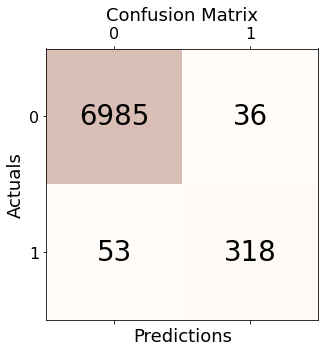

In [51]:
anomaly_predicted = anomaly_predicted_max

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()